# Index

# Hierarchical Bayesian models
## 1 Analyze the dataset
## 2 Design the DAG model
## 3 Graph distributions a posteriori
## 4 degree of convergence and parking for sampling chains

## 1 Analyze the dataset

Load the dataset and verify that its first values

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#Cargar el dataset
df = pd.read_csv("properMotions.csv", delimiter=',' , header=0, names=["experiment", "x", "y", "sigma"])

df.head()

,experiment,x,y,sigma
0,1,0.658605,5.537153,0.292753
1,1,0.592011,5.517838,0.292753
2,1,0.398287,5.547641,0.292753
3,1,0.930757,5.535021,0.292753
4,1,0.145438,5.318424,0.292753


In [ ]:
print(df.shape[0])

print(df["x"].min())
print(df["x"].max())
print(df["y"].min())
print(df["y"].max())

163
0.0134826716966927
0.992547190748155
4.22891409858863
5.95457651005611


In [ ]:
# Número de elementos distintos
num_distintos = df["experiment"].nunique()
print(f"Number of distinct experiments: {num_distintos}")

# Orden de aparición de los elementos distintos
orden_aparicion = list(dict.fromkeys(df["experiment"]))
print("Order of appearance:")
print(orden_aparicion)

Número de experimentos distintos: 7
Orden de aparición:
[1, 2, 3, 4, 5, 6, 7]


In this case the dataset being so small can be observed by inspection, but if it were not the case this is an option for an aribtarian size of the treated dataset.

In [ ]:

cambios = [df["experiment"].iloc[0]]
for valor in df["experiment"].iloc[1:]:
    if valor != cambios[-1]:
        cambios.append(valor)

print("Sequence of experiments as they appear:", cambios)


Secuencia de experimentos según aparecen: [np.int64(1), 2, 3, 4, 5, 6, 7]


Code to check whether or not it is advisable to use a t-student \
Being 163 data and 2 outliers, this means that only 1.2% of the data are. Therefore, we discard this distribution.

In [ ]:
def detectar_outliers(col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df[col] < Q1 - 1.5 * IQR) | (df[col] > Q3 + 1.5 * IQR)]
    return outliers

outliers_x = detectar_outliers("x")
outliers_y = detectar_outliers("y")

print(f"Numbers of outilers in x: {len(outliers_x)}")
print(f"Numbers of outliers in y: {len(outliers_y)}")

Número de outliers en x: 0
Número de outliers en y: 2


We check it visually with two box diagrams, where we see that the two outliers leave the boxes of the box

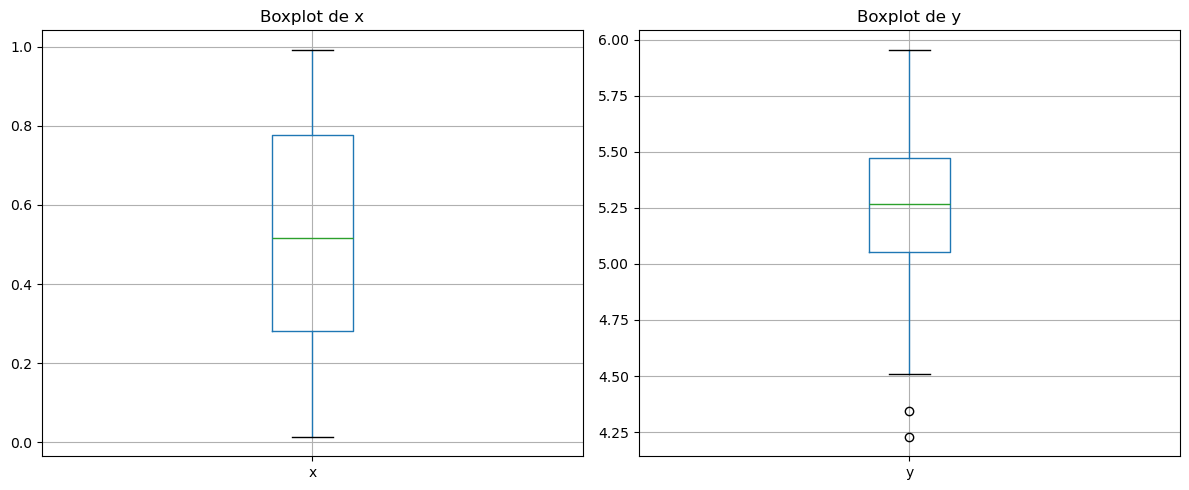

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
df.boxplot(column="x")
plt.title("Boxplot of x")
plt.subplot(1, 2, 2)
df.boxplot(column="y")
plt.title("Boxplot of y")
plt.tight_layout()
plt.show()

## 2 Design the DAG model

We create the model following the steps that appear in the jupyternotebook: intro_pymc.ipynb

In [ ]:
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import numpy as np

# 1 Cargamos datos
df = pd.read_csv("properMotions.csv", header=0, names=["experiment", "x", "y", "sigma"])
N = df["experiment"].nunique()

# Ajustamos para que empiece en 0. Esto muy importante, sino no funciona
df["experiment"] = df["experiment"] - 1

basic_model = pm.Model()

with basic_model:
    # Priors para parámetros globales
    m = pm.Normal("m", mu=0, sigma=10) #Aqui ponemos 10
    b = pm.Normal("b", mu=0, sigma=100) #Aqui en cambio ponemos 100

    # Hiperprior para tau
    tau = pm.HalfCauchy("tau", beta=5)
    
    # Offsets para cada experimento
    o = pm.Normal("o", mu=0, sigma=tau, shape=N)
    
    # Media esperada para cada observación
    mu_y = m * df["x"].values + b + o[df["experiment"].values]

    # Likelihood (sigma_i conocidos por experimento)
    sigma_obs = df["sigma"].values
    y_obs = pm.Normal("y_obs", mu=mu_y, sigma=sigma_obs, observed=df["y"].values)

We show the DAG

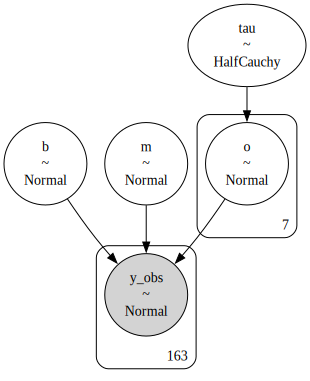

In [ ]:
pm.model_to_graphviz(basic_model)

In [29]:
#Importante ha tardado 6 minutos
with basic_model:  
    # draw 1000 posterior samples 
    posterior = pm.sample(800, tune=800,  random_seed=42, return_inferencedata=False ) 

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [m, b, tau, o]


c:\Users\Ricardo\anaconda3\envs\AAII\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 800 tune and 800 draw iterations (3_200 + 3_200 draws total) took 309 seconds.


In [30]:
print(posterior)
print(posterior.chains)
print(posterior.varnames)  

<MultiTrace: 4 chains, 800 iterations, 5 variables>
[0, 1, 2, 3]
['m', 'b', 'tau_log__', 'o', 'tau']


In [31]:
import arviz as az
print(az.__version__)

0.21.0


## 3 Graph distributions a posteriori

We graph the distributions and their Markov chains.

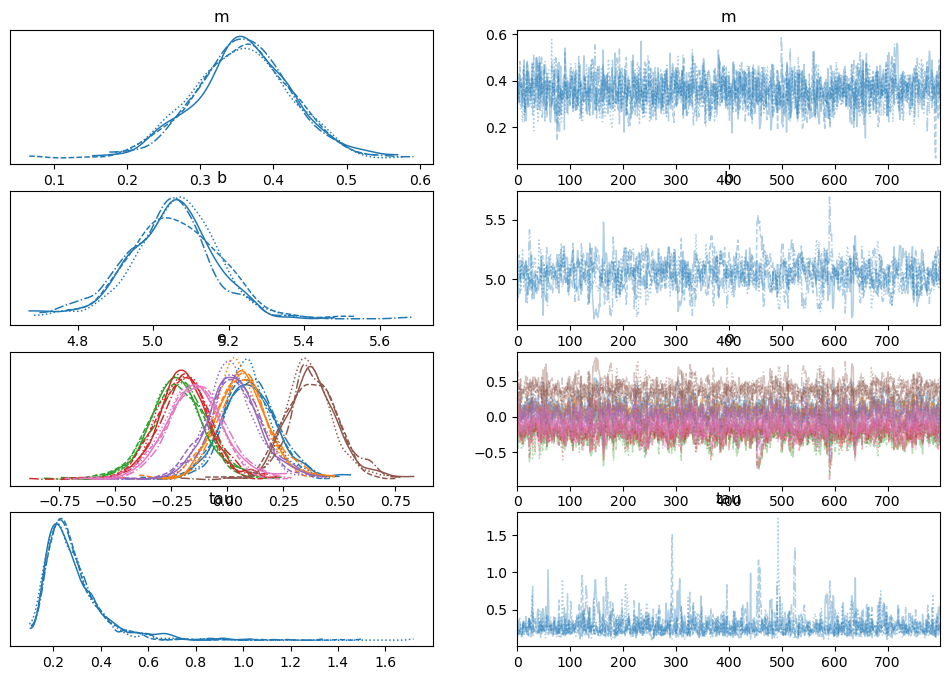

In [32]:
with basic_model:
    idata = pm.to_inference_data(posterior)
    az.plot_trace(idata, combined=False)


The parameters are evaluated in an analytical way

In [ ]:
import numpy as np
import arviz as az

# Función para estimar el modo (MAP) con histograma
def point_estimate_mode(samples, bins=50):
    density, edges = np.histogram(samples, bins=bins)
    max_bin = np.argmax(density)
    return (edges[max_bin] + edges[max_bin + 1]) / 2

with basic_model:
    # 1) MultiTrace sirve para el InferenceData
    idata = pm.to_inference_data(posterior)

    # 2) Resumen numérico
    print(az.summary(idata, var_names=["m", "b", "tau"], round_to=3))

    # 3) Extraemos y aplanamos las muestras de cada parámetro
    m_samps = idata.posterior["m"].values.reshape(-1)
    b_samps = idata.posterior["b"].values.reshape(-1)
    tau_samps = idata.posterior["tau"].values.reshape(-1)

    # 4) Calculamos MAP y HDI (68%)
    map_m = point_estimate_mode(m_samps)
    map_b = point_estimate_mode(b_samps)
    map_tau = point_estimate_mode(tau_samps)

    hdi_m = az.hdi(m_samps, hdi_prob=0.68)
    hdi_b = az.hdi(b_samps, hdi_prob=0.68)
    hdi_tau = az.hdi(tau_samps, hdi_prob=0.68)

# Mostramos resultados
print("\n---------- MAP ---------------")
print(f"m:   {map_m:0.3f}")
print(f"b:   {map_b:0.3f}")
print(f"tau: {map_tau:0.3f}")
print("------------------------------\n")

print("---------- HDI ---------------")
print(f"m:   {hdi_m}")
print(f"b:   {hdi_b}")
print(f"tau: {hdi_tau}")
print("------------------------------")

      mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
m    0.358  0.065   0.238    0.481      0.002    0.001  1718.181  1975.072   
b    5.050  0.117   4.836    5.275      0.005    0.004   587.846   693.271   
tau  0.283  0.129   0.124    0.501      0.004    0.008  1191.897  1028.257   

     r_hat  
m    1.001  
b    1.006  
tau  1.003  

---------- MAP ---------------
m:   0.355
b:   5.068
tau: 0.210
------------------------------

---------- HDI ---------------
m:   [0.29203026 0.41919246]
b:   [4.94129776 5.15970718]
tau: [0.15279862 0.31566292]
------------------------------


Here we show a series of graphics that are an approximation of the subsequent distribution from the samples of Markov's chains. \
In all of them the average appeared, hdi: $\textit{Highest Density Interval}$ o maximum density interval, which is the most reliable range of values ​​of the subsequent distribution. The horizontal line is the HDI interval that tells us that any point within that interval has an equal or greater density to any other point outside it. Basically a way to indicate from at what time the density function is flattened on both sides. The orange vertical line is a reference value established in the code block.The distribution of $b$ seems different but it is because the range of values ​​in the X axis here is greater than in the previous figure, it would really be the same if we decide to graph it with the range of the previous figure.

array([<Axes: title={'center': 'm'}>, <Axes: title={'center': 'b'}>,
       <Axes: title={'center': 'tau'}>], dtype=object)

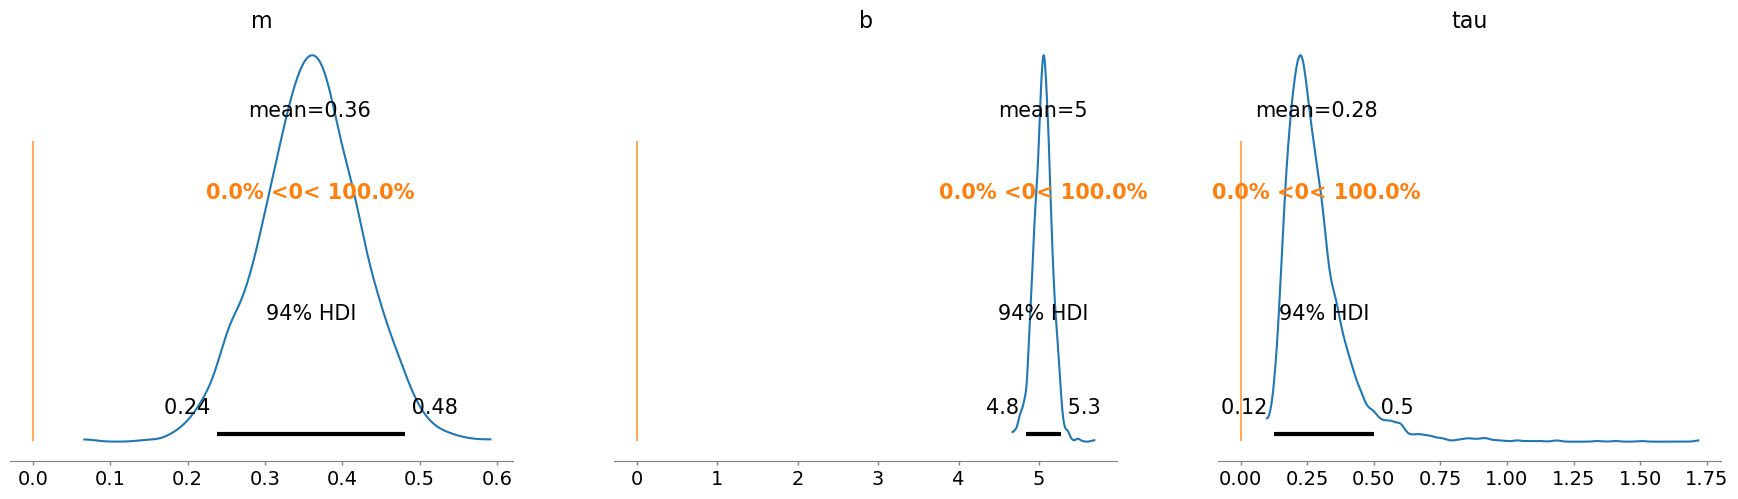

In [ ]:
with basic_model:
    idata = pm.to_inference_data(posterior)

az.plot_posterior(
    idata,
    var_names=["m", "b", "tau"],  
    ref_val=0,
)

Here we comment what we already indicated in the previous figure. There are three groups. Group 1, 2 and 3. Group 1 have its means in negative positions, looking at the orange vertical line we see that, indeed, there are three that have their average under negative values ​​$o_2, o_3$y $o_6$. Group 2 has its average above and with positive values ​​$o_0, o_1$y $o_4$. Group 3 that only has a calibration and its average is above the others is $o_5$. \
Therefore, everything seems correct and with what is seen in the previous figure.

Note: I am aware that the numbering of the calibrations begins in one and not at zero, but in the code blocks I had problems starting the numbering at zero, so he gave up and left it. It is not accidental but deliberate

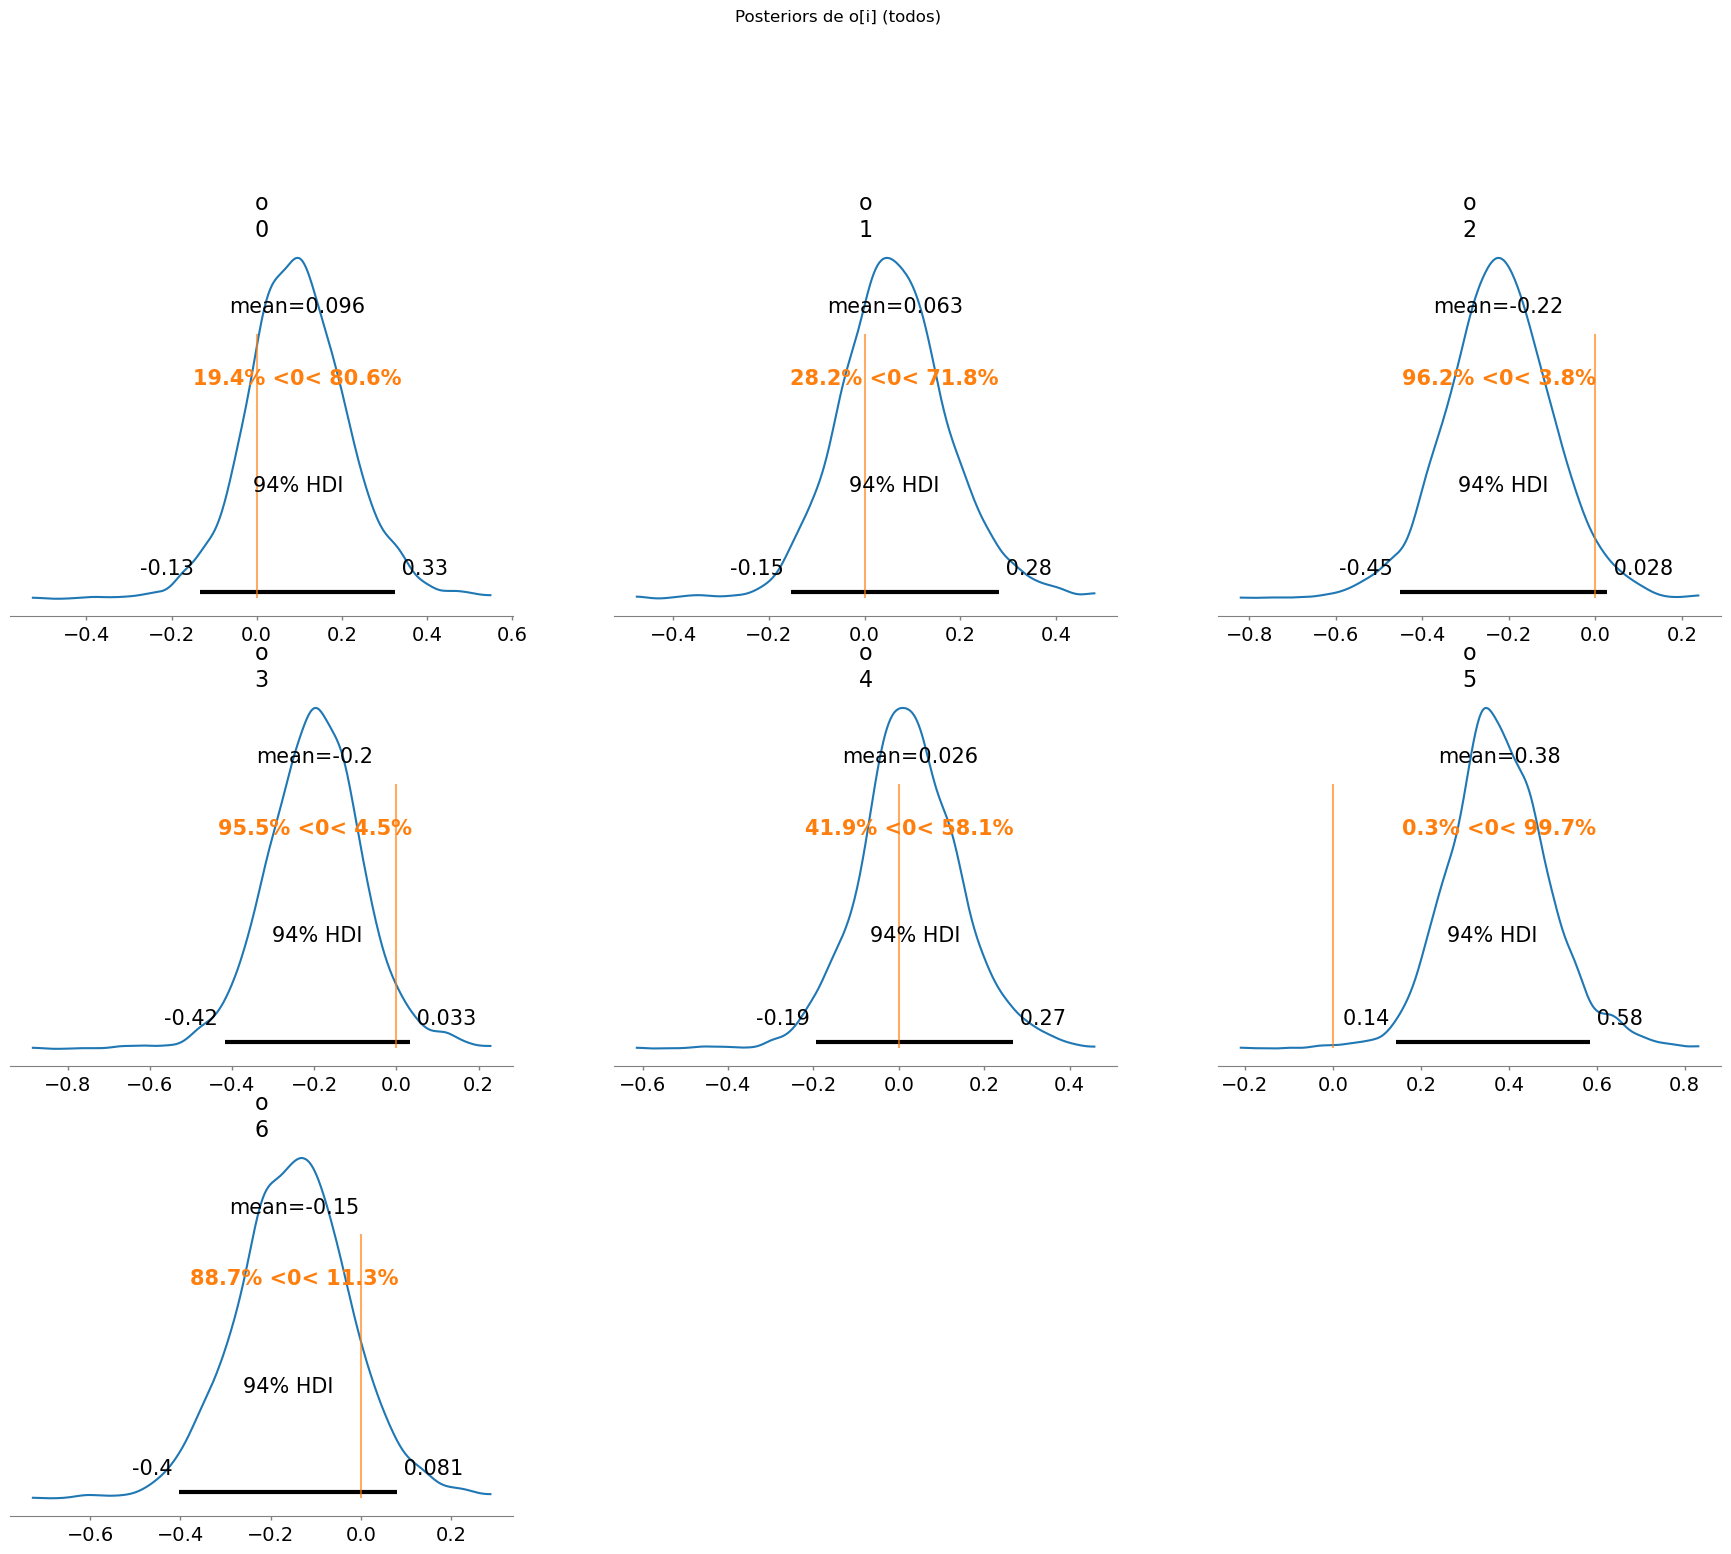

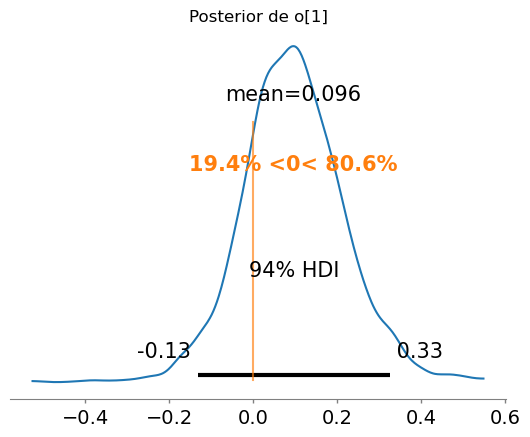

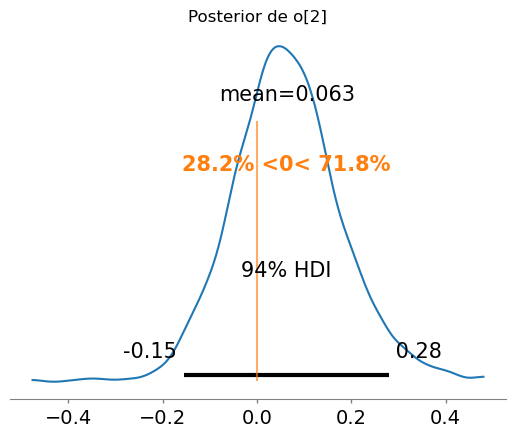

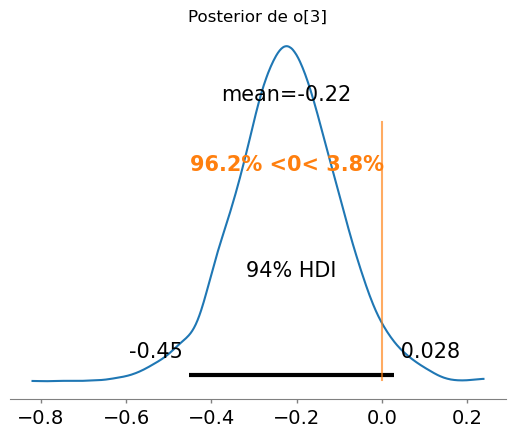

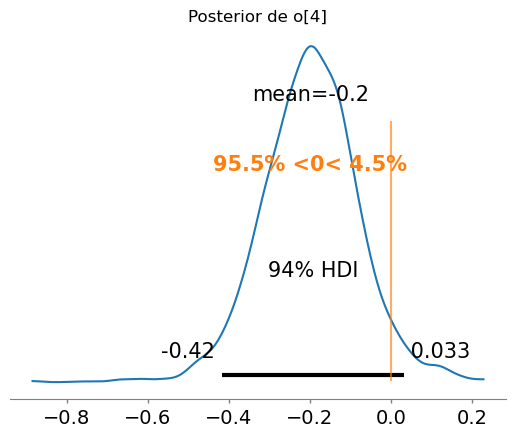

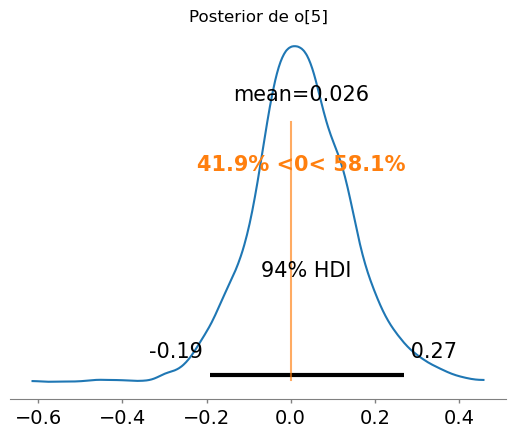

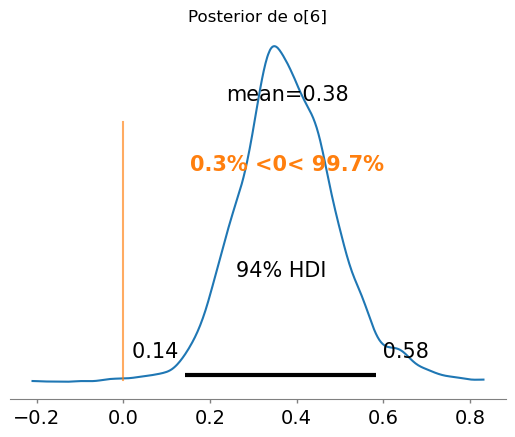

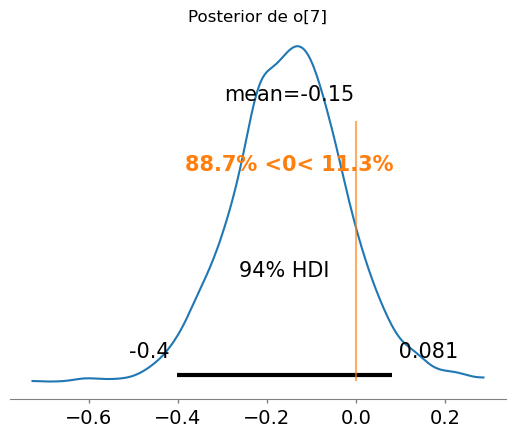

In [ ]:
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import math

with basic_model:
    idata = pm.to_inference_data(posterior)

# 1) Detectamos el nombre de la dimensión de 'o' (distinta de 'chain' y 'draw')
o_var = idata.posterior["o"]
o_dims = [d for d in o_var.dims if d not in ("chain", "draw")]
assert len(o_dims) == 1, f" I wait 1 dim for o, i found it: {o_dims}"
o_dim = o_dims[0]
N = o_var.sizes[o_dim]



labels = np.arange(1, N+1)

# 2) Mostramos cada uno de los o_i en una sola figura
#   ArviZ facetará por índice (o_dim)
az.plot_posterior(
    idata,
    var_names=["o"],
    ref_val=0,
)
plt.suptitle("Posteriors of o[i] (everyones)", y=1.02)
plt.show()

# 3) Mostramos cada uno 
for i, lab in enumerate(labels):
    az.plot_posterior(
        idata,
        var_names=["o"],
        coords={o_dim: i},   # se selecciona el índice i-ésimo
        ref_val=0,
    )
    plt.title(f"Posterior of o[{lab}]")
    plt.show()


## 4 degree of convergence and parking for sampling chains

In [ ]:
import arviz as az
az.summary(idata, var_names=["m","b","tau","o"], round_to=3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
m,0.358,0.065,0.238,0.481,0.002,0.001,1718.181,1975.072,1.001
b,5.050,0.117,4.836,5.275,0.005,0.004,587.846,693.271,1.006
tau,0.283,0.129,0.124,0.501,0.004,0.008,1191.897,1028.257,1.003
o[0],0.096,0.121,-0.132,0.326,0.005,0.004,628.675,795.972,1.006
o[1],0.063,0.117,-0.155,0.280,0.005,0.004,593.349,765.101,1.005
o[2],-0.224,0.126,-0.452,0.028,0.005,0.004,703.761,1033.232,1.004
o[3],-0.198,0.120,-0.417,0.033,0.005,0.004,626.908,879.714,1.005
o[4],0.026,0.121,-0.193,0.269,0.005,0.004,681.751,783.874,1.005
o[5],0.378,0.117,0.143,0.584,0.005,0.004,626.326,679.282,1.005
o[6],-0.149,0.128,-0.403,0.081,0.005,0.004,697.996,961.935,1.004


Let's see that it is every thing in the graphics. \
Each color is a different Markov chain, the discontinuous line is the expected level if the distribution of ranges were uniform. Each vertical bar is the value of the range of a sample in the chain, that is, Order Statistics, as indicated in the Arviz documentation. \
When the chains are well mixed and show the same posterior, chain ranges must be uniform, therefore the bars have similar heights. Instead, Us in the form of a U, peaks, valleys or any other form than the uniform are considered as an indication that we have a bad convergence. \
Observing our case, we can affirm that we are in a uniform case since almost all bars are close to the discontinuous line in the 4 sampled Markov chains.

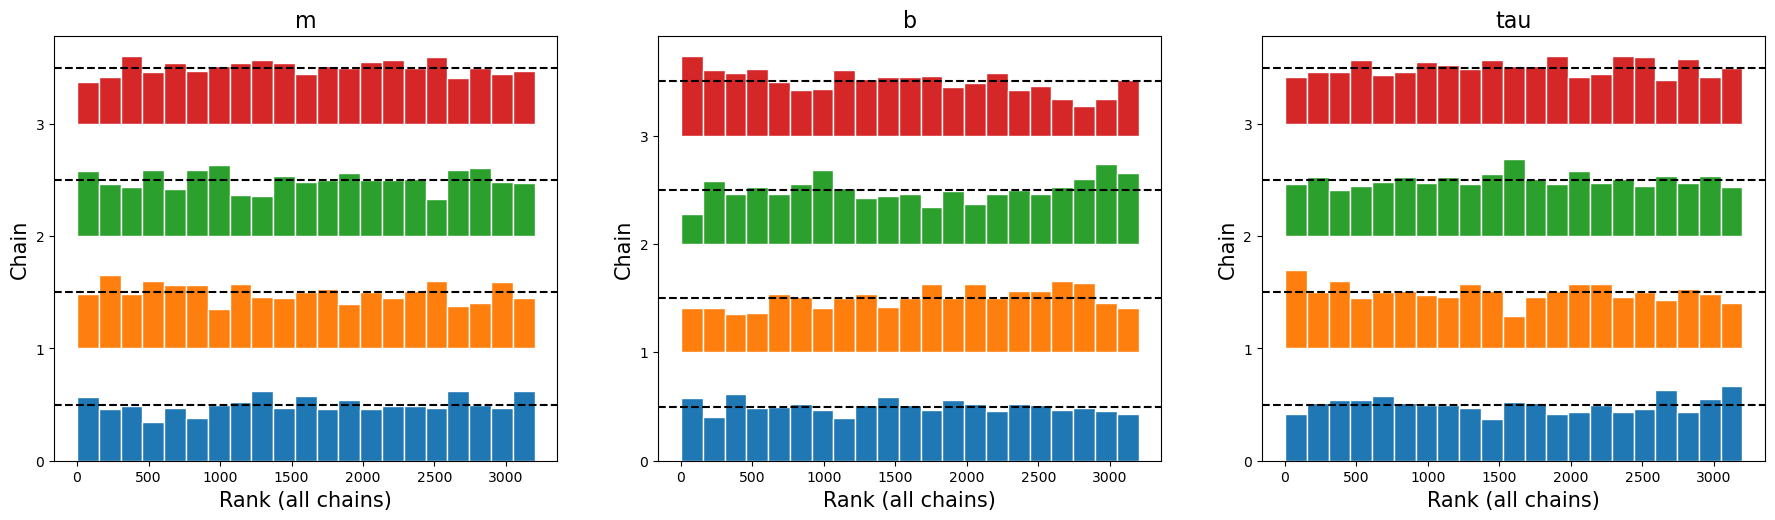

In [48]:
az.plot_rank(idata, var_names=["m","b","tau"]);

Here we show the autocorrelation between the samples. A high correlation manifests a bad mixture while one under manifests a good mixture. Usually, it starts with a high correlation, if it is low fast and also does not rise again we can say that it is a good mixture. \
We see that all cases meet a more or less high correlation and lower rapidly, so they are good mixtures. The worst of them are perhaps the B highlighting $b_0$.

I would like to be able to say more, but I did not find much information about it.

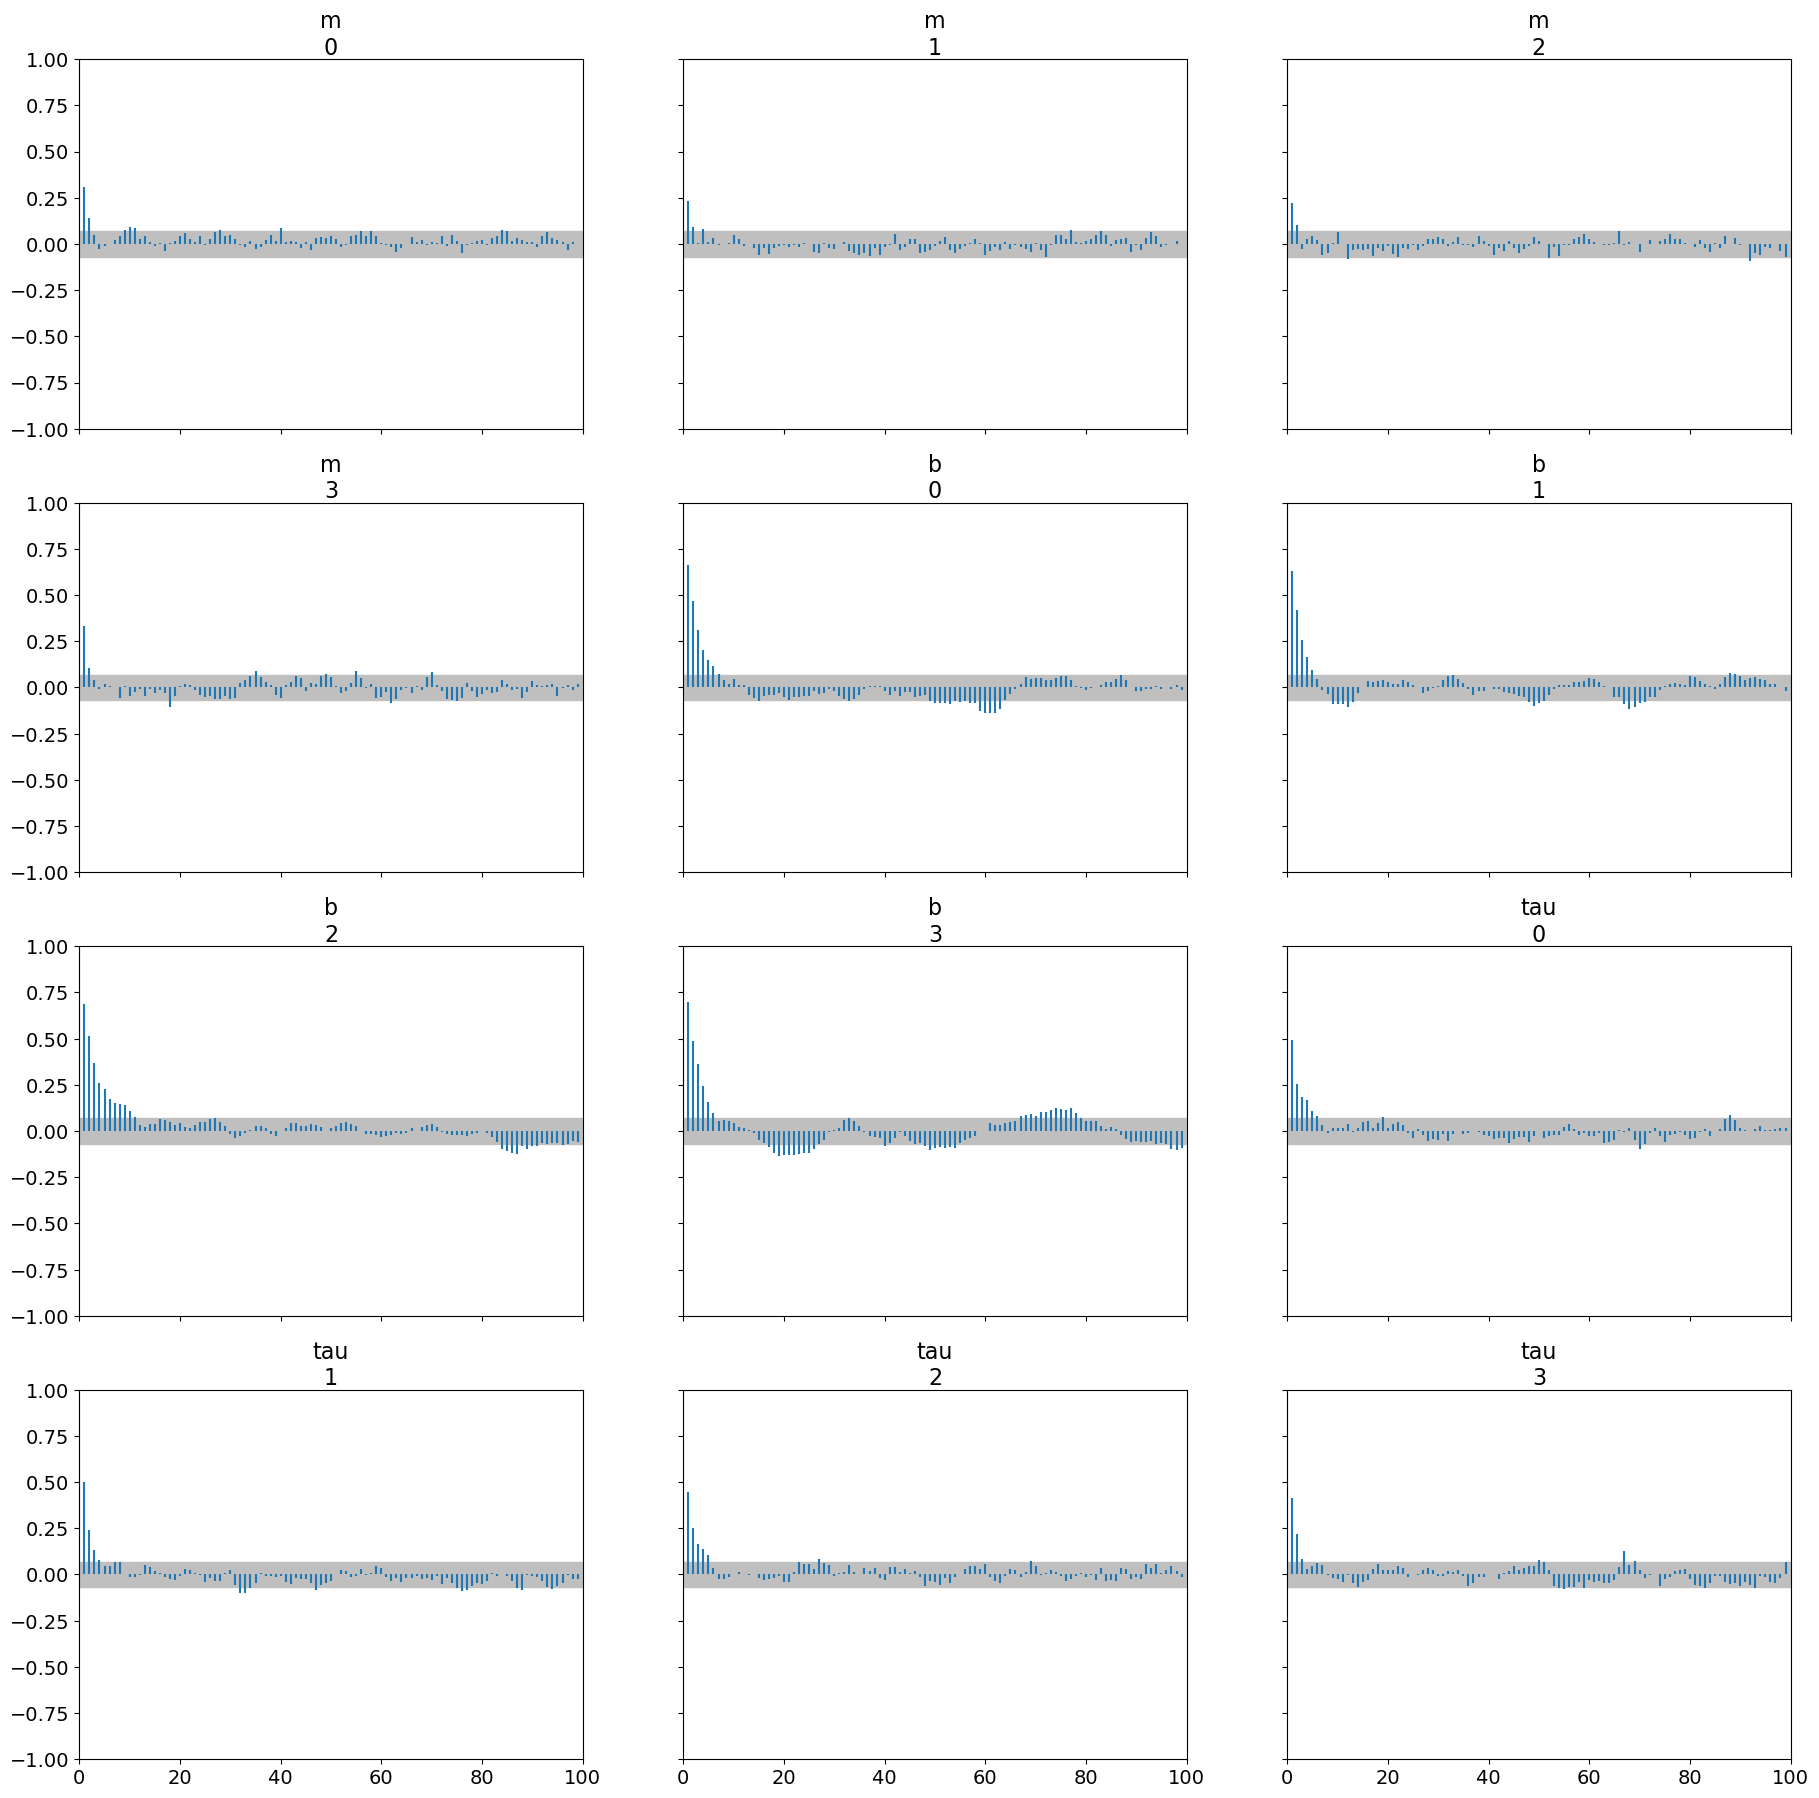

In [53]:
az.plot_autocorr(idata, var_names=["m","b","tau"]);

2) Parking of the chains (are they stabilized?) \
2.1 accumulated average (running mean) by chain 

To study seasonality you have to see Markov's chains together over time. We chose some statistic to evaluate this seasonality, we are interested in the time variable to appear in its expression so we decided on the accumulated average. \
The accumulated mean allows you to average a set of values ​​from time to time $t=0$ until the time considered $t=k$ with $k\in\mathbb{N}$. Its purpose is to see the tendency of something over time, then it suits us for our goal.When graphing we see that both $m$ y $\tau$ has acceptable parking or stabilization since both chains tend to a common point. Instead, who seems to give problem is $b$ since the chains are converged to two different values. The problem can be real, that is, verbally there is a problem of seasonality or calculation, we lack more in the case of $b$.

I would like to try it with more with alone $b$, but it takes a long time to

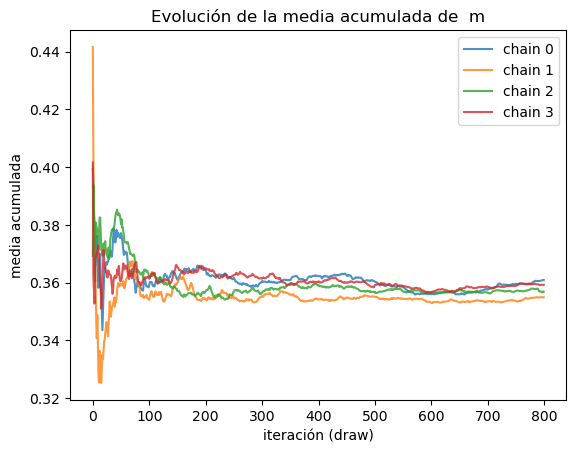

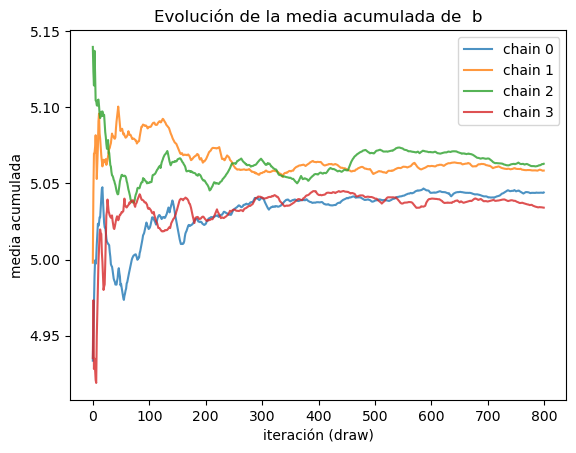

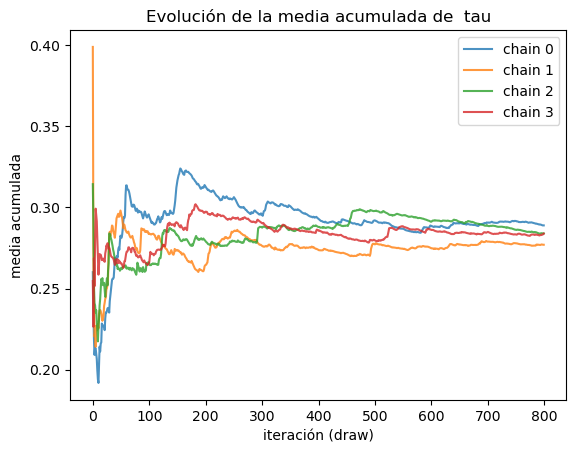

In [ ]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

for var in ["m","b","tau"]:
    da = idata.posterior[var]  # dims: ('chain','draw')
    rm = da.cumsum(dim="draw") / xr.DataArray(
        np.arange(1, da.sizes["draw"] + 1), dims=["draw"]
    )  

    plt.figure()
    for c in da["chain"].values:
        plt.plot(rm.sel(chain=c).values, alpha=0.8, label=f"chain {int(c)}")
    plt.title(f"Evolution of the acumulated mean of   {var}")
    plt.xlabel("Iteration (draw)")
    plt.ylabel("acumulated mean")
    plt.legend()
    plt.show()
